## importing library

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer


## loading and cleaning data

In [33]:
connection = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", connection) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [34]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", connection)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [35]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [36]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [37]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [38]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", connection)
display


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [39]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


In [40]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

## Text PreProcessing :Stemming , StopWord removal and Lemmetization

In [41]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

        

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [11]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'that', 'because', 'am', 'they', 'why', 'by', 'over', 'ourselves', 'so', 'both', "it's", 'such', 'nor', "didn't", 'only', 'will', 'any', "don't", 'no', 'was', 'against', 'just', 'have', 'it', 'himself', "you're", 'wouldn', 'yourselves', "she's", 'more', 'these', 'were', 'being', 'where', 'few', 'between', 'off', 'after', 'some', 'further', 'has', 'are', 'from', 'doing', 'theirs', 'at', "wasn't", 'an', "should've", 'did', "mustn't", 'now', 'shouldn', 'but', 'themselves', 't', "mightn't", 'shan', 'in', "won't", 'her', 'to', 'below', "hadn't", "needn't", 'other', 'about', 'here', 'above', 'under', 'should', 'hasn', 'his', 'the', 'too', "doesn't", 'won', 'i', 'needn', 'aren', "you'd", 'them', 'whom', 'is', 'same', 'yourself', 'doesn', 'm', 'does', 'herself', 'during', 'mustn', 'most', "aren't", 'wasn', 'll', 'ain', 'he', 'don', 'him', 'its', 'into', 'our', 'very', 'you', 'their', 'of', "hasn't", "wouldn't", 'with', 'ma', "haven't", 'then', 'had', 'each', 'be', 'a', 're', 've', 'isn', 'she

In [43]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [44]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [2]:
#connecting to processed data or/and creating new database for processed data
import sqlite3
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
#final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [4]:
# Loading data from the filtered / processed database
filtered_data = pd.read_sql_query("""Select * from reviews""",conn)
filtered_data.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...


In [7]:
#taking data with first 2000 positive scores

#We want to graph t-sne for data , we are using only 2000 data as it takes too much time to run t-sne

final_positive_data = pd.read_sql_query("""Select * from reviews where Score Like 'Positive' LIMIT 2000  """,conn)

#taking data with first 2000 negative scores

final_negative_data = pd.read_sql_query("""Select * from reviews where Score Like 'negative' LIMIT 2000  """,conn)

#concating both positive reviews and negative reviews 
final_data = pd.concat([final_positive_data,final_negative_data],axis=0)
final_data.shape

(4000, 12)

In [9]:
# find sentences containing HTML tags
import re
i=0;
for sent in final_positive_data['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    
    

i=0;
for sent in final_negative_data['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
1
I give five stars to the Maurice Sendak story. One star for this printed edition of the book.<br />My children had an older copy this book, so I was very familiar with the previous softcover version. I ordered this for my granddaughters, but I'm embarrassed to give it as a gift, it looks so puny. The book is about the size of a postcard and I think it's overpriced. I've learned my lesson: I will not be buying any more softco

In [10]:
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'ll', 'after', 'just', "hasn't", 'some', "mustn't", "wasn't", 'between', 'be', 'no', 'we', 'a', 'what', 'which', 'as', 'weren', 'then', 'has', 'should', 'wouldn', 'her', 'ma', 'again', 'in', 'does', 'did', 'she', 'because', 're', 'it', 'further', 'into', 'once', 'themselves', 've', 'yours', "couldn't", 'than', 'off', "isn't", 'theirs', 'd', "that'll", 'not', 'herself', 'hadn', 'such', 'with', 'or', "you're", 's', "it's", 'ourselves', 'now', 'his', 'who', 'from', 'under', "mightn't", 'each', 'so', 'are', "won't", 'can', 'the', 'its', 'while', "shouldn't", 'ain', 'had', 'other', 'at', 'haven', 'own', 'few', 'out', 'very', 'mustn', 'shouldn', 'were', 'having', 'but', 'during', 'an', 'nor', 'ours', "wouldn't", 'our', 'where', 'if', 'too', 'above', 'myself', "didn't", 'up', "shan't", 'itself', 'been', 'have', "should've", 'to', 'and', 'he', 'those', 'aren', "haven't", 'against', 't', 'doing', "needn't", 'down', 'over', 'most', 'y', 'on', "she's", 'hers', 'didn', 'won', 'my', 'am', 'more', 

In [11]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_data_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final_data['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final_data['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final_data['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final_data string of cleaned words
    #print("***********************************************************************")
    
    final_data_string.append(str1)
    i+=1

In [12]:
final_data['CleanedText']=final_data_string

In [13]:
final_data.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...


# BAG OF WORDS

In [55]:
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final_data['Text'].values)

#

In [56]:
type(final_counts)

scipy.sparse.csr.csr_matrix

In [57]:
final_counts.get_shape()

(4000, 15220)

In [58]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'food', 1471), (b'dog', 1362), (b'cat', 1111), (b'one', 978), (b'trap', 949), (b'love', 883), (b'use', 831), (b'get', 777), (b'like', 769), (b'treat', 639), (b'great', 600), (b'well', 554), (b'product', 542), (b'good', 541), (b'mole', 502), (b'tri', 495), (b'year', 491), (b'time', 456), (b'day', 450), (b'would', 429)]
Most Common Negative Words :  [(b'product', 911), (b'like', 844), (b'tast', 792), (b'one', 708), (b'food', 600), (b'would', 593), (b'use', 591), (b'get', 521), (b'tri', 514), (b'order', 500), (b'good', 496), (b'buy', 460), (b'flavor', 416), (b'dog', 404), (b'dont', 400), (b'time', 397), (b'look', 394), (b'coffe', 391), (b'even', 385), (b'make', 374)]


In [22]:
labels = final_data['Score']
labels.shape

(4000,)

In [60]:
#t-sne for bag of words

bow_tsne=final_counts.toarray()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
model =scaler.fit(bow_tsne)
bow_tsne=scaler.transform(bow_tsne)

/Users/sapansoni/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


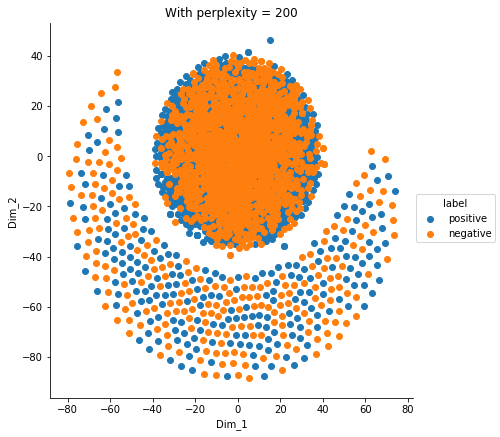

In [61]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0,perplexity=200)
bow_tsne = model.fit_transform(bow_tsne)

bow_tsne = np.vstack((bow_tsne.T, labels)).T
tsne_df = pd.DataFrame(data=bow_tsne, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 200')
plt.show()

From the above t-sne plot , we are not able to diffrentiate between negative and positive points 
So Bag of Word is not a good method for this Problem

# TF-IDF

In [14]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final_data['Text'].values)


In [15]:
final_tf_idf.get_shape()

(4000, 158520)

In [16]:
features = tf_idf_vect.get_feature_names()
len(features)

158520

In [17]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)

In [18]:
top_tfidf

,feature,tfidf
0,two hands,0.142905
1,rosie movie,0.142905
2,hands to,0.142905
3,incorporates,0.142905
4,sendak books,0.142905
5,reading these,0.142905
6,incorporates them,0.142905
7,the paperbacks,0.142905
8,pages open,0.142905
9,that incorporates,0.142905


In [19]:
#tsne representation of tfidf
tf_idf_tsne=final_tf_idf.toarray()

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
model =scaler.fit(tf_idf_tsne)



tf_idf_tsne=scaler.transform(tf_idf_tsne)

In [20]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0,perplexity=200)
tsne_data = model.fit_transform(tf_idf_tsne)



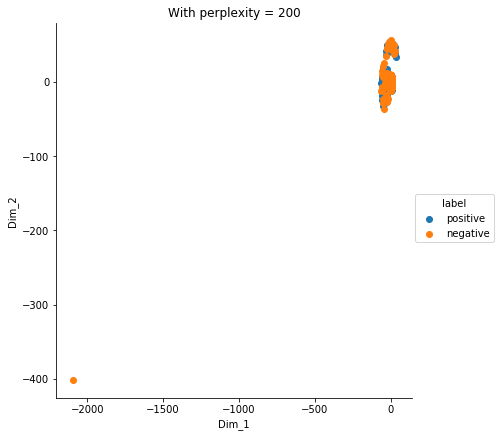

In [23]:
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 200')
plt.show()


From the above t-sne plot , we are not able to diffrentiate between negative and positive points 
So IF-IDF is not a good method for this problem


# Word2Vec

In [ ]:
aaa

In [29]:
# Using Google News Word2Vectors
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)


In [30]:
model.wv['computer']
model.wv.similarity('woman', 'man')
model.wv.most_similar('woman')
#model.wv.most_similar('tasti')  # "tasti" is the stemmed word for tasty, tastful
model.wv.most_similar('tasty') 
model.wv.similarity('tasty', 'tast')



/Users/sapansoni/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/Users/sapansoni/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/Users/sapansoni/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/Users/sapansoni/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sapansoni/anaconda3/li

0.44035053

In [30]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sentence=[]
for sentence in final_data['Text'].values:
    filtered_sentence=[]
    sentence=cleanhtml(sentence)
    for words in sentence.split():
        for cleaned_words in cleanpunc(words).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sentence.append(filtered_sentence)
    

In [34]:
print(final_data['Text'].values[0])
print("*****************************************************************")
print(list_of_sentence[0])

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
*****************************************************************
['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'recite', 'it', 'in', 'the', 'car', 'as', 'were', 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'the', 'refrain', 'hes', 'learned', 'about', 'whales', 'india', 'drooping', 'i', 'love', 'all', 'the', 'new', 'words', 'this', 'book', 'introduces', 'and', 'the', 'silliness', 'of', 'it', 'all', 'this', 'is', 'a', 'classic', 'book', 'i', 'am', 'willing', 'to', 'bet', 'my', 'son', 'will', 'still', 'be', 'able', 'to', 'recite', 'from', 'memory', 'when', 'he', 'is'

In [36]:
w2v_model=gensim.models.Word2Vec(list_of_sentence,min_count=5,size=50, workers=4)    


In [37]:
words = list(w2v_model.wv.vocab)
print(len(words))

4379


In [38]:
w2v_model.wv.most_similar('tasty')

/Users/sapansoni/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('inexpensive', 0.9941112399101257),
 ('vibrant', 0.9879404902458191),
 ('enjoyable', 0.9859380125999451),
 ('powerful', 0.9828982353210449),
 ('tough', 0.9824314713478088),
 ('reusable', 0.980272650718689),
 ('extremely', 0.9797359704971313),
 ('advertised', 0.9794171452522278),
 ('awesome', 0.978480875492096),
 ('news', 0.9782752394676208)]

In [39]:
w2v_model.wv.most_similar('like')

/Users/sapansoni/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('too', 0.8629299998283386),
 ('taste', 0.8590816259384155),
 ('overfeed', 0.8551812171936035),
 ('worth', 0.8547216653823853),
 ('tastes', 0.8542219996452332),
 ('but', 0.85322505235672),
 ('does', 0.8479660749435425),
 ('carnivore', 0.842545747756958),
 ('makes', 0.8377829790115356),
 ('looks', 0.8305520415306091)]

In [41]:
w2v_model

In [42]:
# average Word2Vec
# compute average word2vec for each review.
sentence_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in list_of_sentence: # for each review/sentence
    sentence_vector = np.zeros(50) # as word vectors are of zero length
    count_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence: # for each word in a review/sentence
        try:
            vector = w2v_model.wv[word]
            sentence_vector += vector
            count_words += 1
        except:
            pass
    sentence_vector /= count_words
    sentence_vectors.append(sentence_vector)
print(len(sentence_vectors))
print(len(sentence_vectors[0]))

4000
50


In [40]:
a=pd.DataFrame(data=sentence_vectors)
a.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.592887,0.338757,-0.306553,-0.057205,0.129584,-0.307864,-0.219325,-0.636584,0.128689,-0.240621,...,0.351505,0.173544,-0.238292,0.314528,-0.344885,0.214710,-0.446797,-0.148563,-0.318978,0.280451
1,0.573802,0.394676,-0.355396,-0.133358,0.274689,-0.379080,-0.296679,-0.541869,-0.012659,-0.310089,...,0.464922,0.136642,-0.236492,0.268357,-0.304304,0.275333,-0.469012,-0.196615,-0.445333,0.334406
2,0.600809,0.346613,-0.367761,-0.264138,0.218345,-0.419351,-0.273137,-0.796950,-0.120826,-0.258115,...,0.276629,0.096703,-0.308642,0.305180,-0.446811,0.134550,-0.508642,-0.285758,-0.259467,0.203252
3,0.642887,0.365690,-0.348514,-0.138323,0.222361,-0.418384,-0.261588,-0.663267,0.030303,-0.291220,...,0.422306,0.197633,-0.233628,0.378965,-0.383388,0.163846,-0.529482,-0.279070,-0.302528,0.144798
4,0.630879,0.331856,-0.361294,-0.084585,0.100079,-0.388047,-0.219207,-0.768590,0.074463,-0.193698,...,0.302619,0.184672,-0.286851,0.425407,-0.478444,0.179248,-0.519251,-0.165128,-0.138882,0.313454


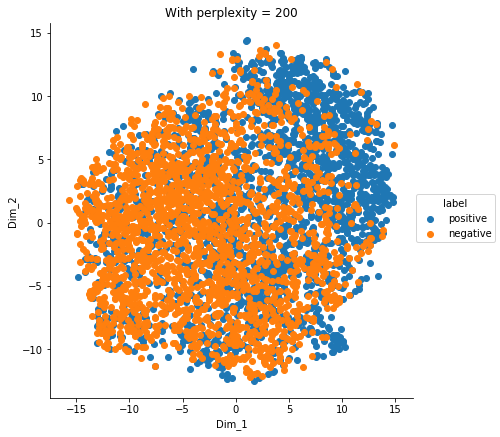

In [41]:
    #tsne representation of avg W2V
tf_idf_tsne=a

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
model =scaler.fit(tf_idf_tsne)



tf_idf_tsne=scaler.transform(tf_idf_tsne)
sentence_vectors

from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0,perplexity=200)
tsne_data = model.fit_transform(sentence_vectors)

tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 200')
plt.show()


In Avg Word2Vec we can see that Posive and Negative labels are quite diffrentiated from each other.
So we can say that Avg Word2Vec is better method to solve this problem

# TF-IDF Avg Word2Vec

In [43]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentence: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    

    

In [44]:
tfidf_sent_vectors

[array([ 0.10093871, -0.22983126,  0.02973099,  0.22385333, -0.12324818,
         0.40155291,  0.51550604,  0.08193766,  0.21786961,  0.22158352,
         0.02135993,  0.28589867, -0.03676462,  0.35152912,  0.20593751,
         0.0039205 ,  0.04218944,  0.13855273, -0.03002925,  0.19421955,
         0.03791837, -0.2837075 ,  0.13659546,  0.38523483, -0.26982635,
        -0.45105644, -0.01318067,  0.07240285, -0.17780764,  0.26878702,
         0.18492361, -0.13983542, -0.09891225, -0.62864151,  0.32143689,
         0.56914596, -0.38334289,  0.18386986,  0.08169376, -0.54337049,
        -0.20176557, -0.1525832 , -0.04459968,  0.35464642,  0.70192546,
         0.00996545,  0.36130205,  0.17657367, -0.01364657, -0.10948951]),
 array([ 0.06874855, -0.13640783,  0.09639042,  0.30763077, -0.18919828,
         0.46878419,  0.5787825 , -0.06994217,  0.19523964,  0.20502367,
        -0.14901881,  0.14205407, -0.12758162,  0.41226541,  0.1741494 ,
        -0.09419203,  0.27501534,  0.10147531,  0

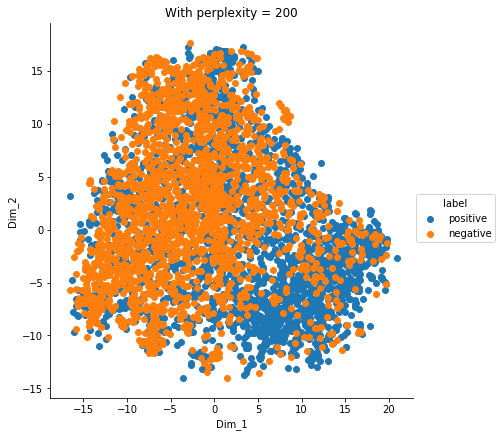

In [46]:
#tsne representation of avg W2V

#tfidf_sentence_vectors

from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0,perplexity=200)
tsne_data = model.fit_transform(tfidf_sent_vectors)

tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 200')
plt.show()


In Avg Word2vec TF-IDF we can see that Posive and Negative labels are quite diffrentiated from each other.
So we can say that Avg Word2Vec is better method to solve this problem

# Conclusion

We have used t-SNE to plot higher dimension data to 2D data so that we can visualize the relation between positive and negative reviews
From the above plots we can conclude as below:

1. Most of the TSNE plot showt that data is quite overlapping and we cant be sure that data is separable also TSNE is an approximation algorithm 
2. We should either use Average Word2Vec or TF-IDF Average Word2Vec method for this problem.
3. Also we have done this for very small dataset(2000 for each class) so result may vary if we use larger data points.